# Restricted Boltzmann Machines on MNIST (NumPy implementation)
1. [Load MNIST](#1.-Load-MNIST)  
    1.1 [Look at some images](#1.1-Look-at-some-images)  
    1.2 [Compute avg_train_img](#1.2-Compute-avg\_train\_img)  
2. [RBM](#2.-RBM)  
    2.1 [Implementation](#2.1-Implementation)  
    2.2 [Training](#2.2-Training)    
      2.2.1 [Contrastive Divergence](#2.2.1-Contrastive-Divergence)  
      2.2.2 [Persistent Contrastive Divergence](#2.2.2-Persistent-Contrastive-Divergence)  
      2.2.3 [Parallel Tempering](#2.2.3-Parallel-Tempering)  
    2.3 [Visualizing Learning](#2.3-Visualizing-Learning)  
      2.3.1 [Look at some reconstructed images during training](#2.3.1-Look-at-some-reconstructed-images-during-training)  
      2.3.2 [Look at the weights during training](#2.3.2-Look-at-the-weights-during-training)  
      2.3.3 [Look at the final weights](#2.3.3-Look-at-the-final-weights)  
3. [Applications](#3.-Applications)  
    3.1 [Digits generation](#3.1-Digits-generation)  
    3.2 [Digits restoration](#3.2-Digits-restoration)  

In [1]:
import mnist
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

%matplotlib inline
np.random.seed(67)

In [2]:
print(f'sys.version: {sys.version}')

sys.version: 3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 19:16:44) 
[GCC 7.3.0]


## 1. Load MNIST

In [3]:
X_train = mnist.train_images().reshape(-1, 28 * 28) / 255.
y_train = mnist.train_labels()
X_test = mnist.test_images().reshape(-1, 28 * 28) / 255.
y_test = mnist.test_labels()

print(f'X_train: dtype={X_train.dtype}, shape={X_train.shape}, min_max=[{X_train.min()}, {X_train.max()}]')
print(f'y_train: dtype={y_train.dtype}, shape={y_train.shape}, min_max=[{y_train.min()}, {y_train.max()}]\n')
print(f'X_test: dtype={X_test.dtype}, shape={X_test.shape}, min_max=[{X_test.min()}, {X_test.max()}]')
print(f'y_test: dtype={y_test.dtype}, shape={y_test.shape}, min_max=[{y_test.min()}, {y_test.max()}]')

X_train: dtype=float64, shape=(60000, 784), min_max=[0.0, 1.0]
y_train: dtype=uint8, shape=(60000,), min_max=[0, 9]

X_test: dtype=float64, shape=(10000, 784), min_max=[0.0, 1.0]
y_test: dtype=uint8, shape=(10000,), min_max=[0, 9]


### 1.1 Look at some images

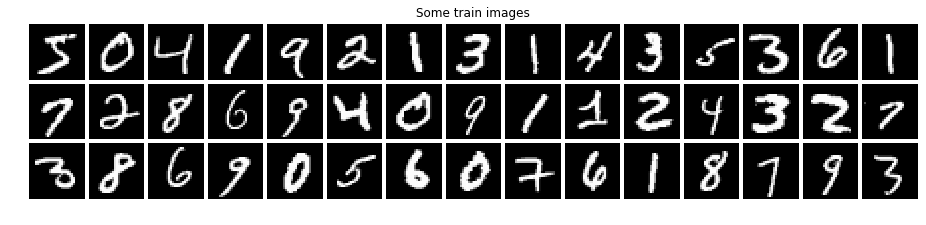

In [4]:
def grid_vis(X, rows=3, cols=3, pad=1):
    X_reshaped = X[:rows*cols].reshape(-1, 28, 28)
    
    g_d1 = rows
    g_d2 = 28 + 2 * pad
    g_d3 = g_d2 * cols
    grid_rows = np.zeros((g_d1, g_d2, g_d3))
    
    for i in range(rows):
        start_idx = i * cols
        end_idx = (i + 1) * cols
        X_pad = np.pad(X_reshaped[start_idx:end_idx], 
                       [(0,), (pad,), (pad,)], 
                       'constant', constant_values=1)
        grid_rows[i] = np.concatenate(X_pad, axis=1)
                         
    return np.concatenate(grid_rows, axis=0)


def add_text(text, x=3, w=30):
    for s in text:
        plt.text(x, -3, s)
        x += w

# plot some images using grid_vis
plt.figure(figsize=(16, 5))
plt.title('Some train images')
grid_imgs = grid_vis(X_train, rows=3, cols=15)
plt.imshow(grid_imgs, cmap='gray')
plt.axis('off')
plt.show()

### 1.2 Compute avg_train_img
__These values will be used to initialize biases for visible units.__  
[A Practical Guide to Training Restricted Boltzmann Machines (Hinton, 2010)](http://www.cs.toronto.edu/~hinton/absps/guideTR.pdf)

avg_train_img.shape: (784, 1)


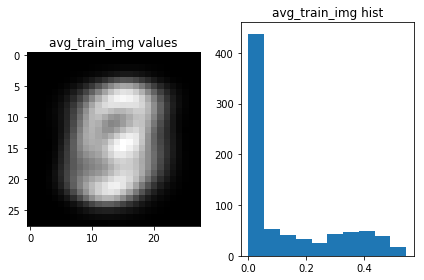

In [5]:
avg_train_img = np.mean(X_train, axis=0)[:, None]
print(f'avg_train_img.shape: {avg_train_img.shape}')

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(avg_train_img.reshape(28, 28), cmap='gray')
plt.title('avg_train_img values')

plt.subplot(1, 2, 2)
plt.hist(avg_train_img)
plt.title('avg_train_img hist')
plt.tight_layout()
plt.show()

## 2. RBM

In [6]:
# aux functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def norm_img(img):
    img_min = img.min()
    img_max = img.max()
    img_norm = (img - img_min) / (img_max - img_min)
    return img_norm

def xor_swap(a, b):
    a ^= b
    b ^= a
    a ^= b

### 2.1 Implementation

In [7]:
class RBM:
    def __init__(self, vis_dim=784, hidden_dim=200, avg_train_img=None):
        self.hidden_dim = hidden_dim
        self.vis_dim = vis_dim
        
        # init bias of hidden layer
        self.h_bias = np.zeros((self.hidden_dim, 1))
        
        # init bias of visible layer
        self.v_bias = np.zeros((self.vis_dim, 1))
        if avg_train_img is not None:
            # added 1e-20 for numerical stability
            self.v_bias = np.log((avg_train_img + 1e-20) / (1 - avg_train_img + 1e-20))
        
        # prepare params for training
        self.w = 1e-2 * np.random.randn(self.hidden_dim, self.vis_dim)
    
    
    def energy(self, v, h):
        e = - np.diag(h.dot(self.w.dot(v.T)))[:, None]\
            - v.dot(self.v_bias)\
            - h.dot(self.h_bias)
        return e
    
    
    def h_prob_given_v(self, v, t=1):
        return sigmoid((np.dot(v, self.w.T) + self.h_bias.T) / t)
    
    
    def sample_h_given_v(self, v, t):
        h_prob = self.h_prob_given_v(v, t)
        h = h_prob >= np.random.uniform(0, 1, h_prob.shape)
        return h
    
    
    def sample_v_given_h(self, h, t):
        v_prob = sigmoid((np.dot(h, self.w) + self.v_bias.T) / t)
        v = v_prob >= np.random.uniform(0, 1, v_prob.shape)
        return v
    
    
    def gibbs_sampling(self, v, k, t=1):
        for _ in range(k):
            h = self.sample_h_given_v(v, t)
            v = self.sample_v_given_h(h, t)
        return v
    
    
    def exchange_particles(self, x_neg_sample_all_temps, t, batch_size):
        t_size = len(t)
        h = np.zeros((t_size * batch_size, self.hidden_dim))
        
        for t_idx in np.random.permutation(range(1, t_size)):
            v = x_neg_sample_all_temps
            h[t_idx::t_size] = self.sample_h_given_v(v[t_idx::t_size], t[t_idx])
            h[t_idx-1::t_size] = self.sample_h_given_v(v[t_idx-1::t_size], t[t_idx-1])

            t_diff = 1. / t[t_idx] - 1. / t[t_idx-1]
            e_diff = self.energy(v[t_idx::t_size], h[t_idx::t_size])\
                        -\
                     self.energy(v[t_idx-1::t_size], h[t_idx-1::t_size])
            exchange_prob = np.minimum(1, np.exp(t_diff * e_diff))
            exchange_mask = exchange_prob >= np.random.uniform(0, 1, exchange_prob.shape)
            indices = np.nonzero(exchange_mask)[0]

        # xor swap
        xor_swap(x_neg_sample_all_temps[indices],
                 x_neg_sample_all_temps[indices-1])    
    
    
    def train(self, X, epochs=10, batch_size=30, lr=1e-2,
              training_method='cd', gibbs_steps=1, t_size=1):
        N = X.shape[0]
        start_indices = list(range(0, N, batch_size))
        end_indices = list(range(batch_size, N, batch_size))
        if end_indices[-1] != N:
            end_indices.append(N)
        
        train_evolution = {}
        train_evolution['training_method'] = training_method
        train_evolution['gibbs_steps'] = gibbs_steps
        train_evolution['batch_size'] = batch_size
        train_evolution[0] = {}
        train_evolution[0]['img'] = X_train[:10].copy()
        train_evolution[0]['w'] = self.w.copy()
        
        # init x_neg_sample for 'pcd'
        x_neg_sample = None
        
        # init x_neg_sample_all for 'pt'
        x_neg_sample_all_temps = None
        
        # temperatures
        t = 1
        if training_method == 'pt':
            t = np.arange(1, t_size + 1, dtype=np.float) # t: [1., 2., ..., t_size]
            t = np.tile(t, batch_size)[:, None] # t.shape: (t_size * batch_size, 1)
        
        for epoch in tqdm(range(epochs)):
            for (start_idx, end_idx) in zip(start_indices, end_indices):
                # slice a training mini-batch
                x0 = X_train[start_idx:end_idx]
                
                # prepare x_start for 'cd', 'pcd' and 'pt' training methods
                x_start = None
                if training_method == 'cd':
                    x_start = x0
                elif training_method == 'pcd':
                    x_start = x_neg_sample if x_neg_sample is not None else x0
                elif training_method == 'pt':
                    x_start = x_neg_sample_all_temps
                    if x_start is None:
                        x_start = np.repeat(x0, t_size, axis=0)
                
                # gibbs sampling
                x_neg_sample_all_temps = self.gibbs_sampling(x_start, gibbs_steps, t)
                
                # just for 'pt' training method: exchange particles
                if training_method == 'pt':
                    self.exchange_particles(x_neg_sample_all_temps, t, batch_size)
                
                # use neg samples with temperature t=1 (eventually exchanged in case of 'pt')
                x_neg_sample = x_neg_sample_all_temps[::t_size, :]
                
                # update weights and biases
                dw_pos_phase = np.dot(self.h_prob_given_v(x0).T, x0)
                dw_neg_phase = np.dot(self.h_prob_given_v(x_neg_sample).T, x_neg_sample)
                self.w += lr * (dw_pos_phase - dw_neg_phase)
                
                dh_bias_pos_phase = self.h_prob_given_v(x0)
                dh_bias_neg_phase = self.h_prob_given_v(x_neg_sample)
                self.h_bias += lr * np.mean(dh_bias_pos_phase - dh_bias_neg_phase, axis=0)[:, None]
                
                self.v_bias += lr * np.mean(x0 - x_neg_sample, axis=0)[:, None]
            
            # save neg samples and weights for every epoch
            train_evolution[epoch + 1] = {}
            train_evolution[epoch + 1]['img'] = self.gibbs_sampling(X_train[:10], 
                                                                    gibbs_steps)
            train_evolution[epoch + 1]['w'] = self.w.copy()
            
        return train_evolution

In [8]:
EPOCHS = 15
BATCH_SIZE = 30
GIBBS_STEPS = 1
HIDDEN_DIM = 200
VIS_DIM = 28 * 28

def train_RBM(training_method='cd', t_size=1):
    rbm = RBM(vis_dim=VIS_DIM,
              hidden_dim=HIDDEN_DIM,
              avg_train_img=avg_train_img)

    train_evolution = rbm.train(X_train,
                                training_method=training_method,
                                gibbs_steps=GIBBS_STEPS,
                                epochs=EPOCHS,
                                batch_size=BATCH_SIZE,
                                t_size=t_size)
    
    return rbm, train_evolution

### 2.2 Training

#### 2.2.1 Contrastive Divergence

In [9]:
rbm_cd, rbm_cd_train_evolution = train_RBM(training_method='cd')

100%|██████████| 15/15 [02:47<00:00, 10.03s/it]


#### 2.2.2 Persistent Contrastive Divergence

In [10]:
rbm_pcd, rbm_pcd_train_evolution = train_RBM(training_method='pcd')

100%|██████████| 15/15 [02:31<00:00, 10.23s/it]


#### 2.2.3 Parallel Tempering

In [11]:
rbm_pt, rbm_pt_train_evolution = train_RBM(training_method='pt', t_size=10)

100%|██████████| 15/15 [47:12<00:00, 185.32s/it]


### 2.3 Visualizing Learning

#### 2.3.1 Look at some reconstructed images during training

                                                   [TRAIN EVOLUTION]
                                                 training_method: cd
                                                      gibbs_steps: 1
                                                      batch_size: 30


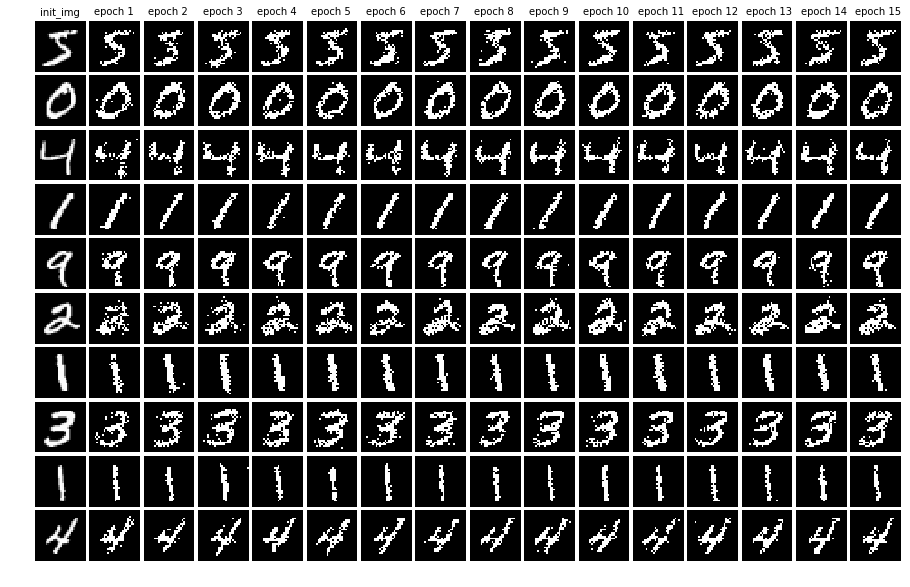

                                                   [TRAIN EVOLUTION]
                                                training_method: pcd
                                                      gibbs_steps: 1
                                                      batch_size: 30


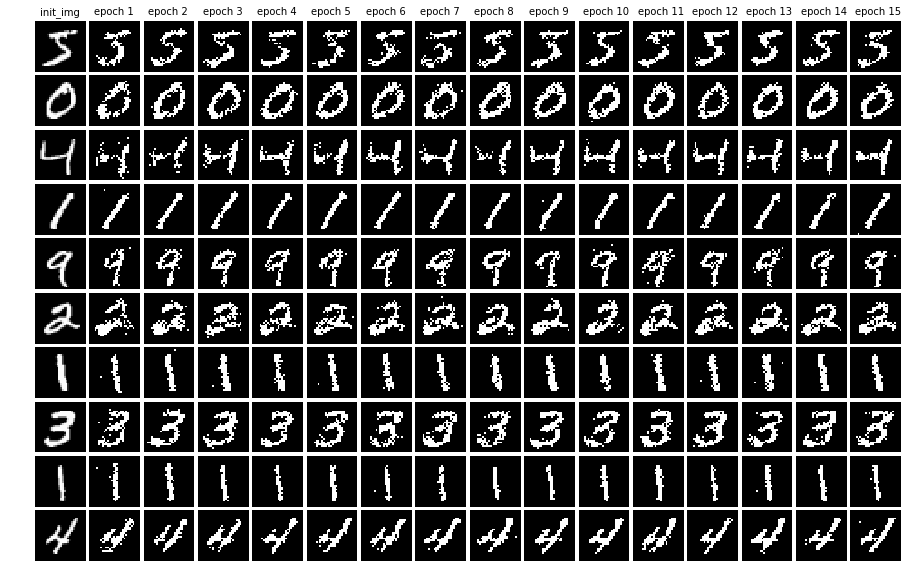

                                                   [TRAIN EVOLUTION]
                                                 training_method: pt
                                                      gibbs_steps: 1
                                                      batch_size: 30


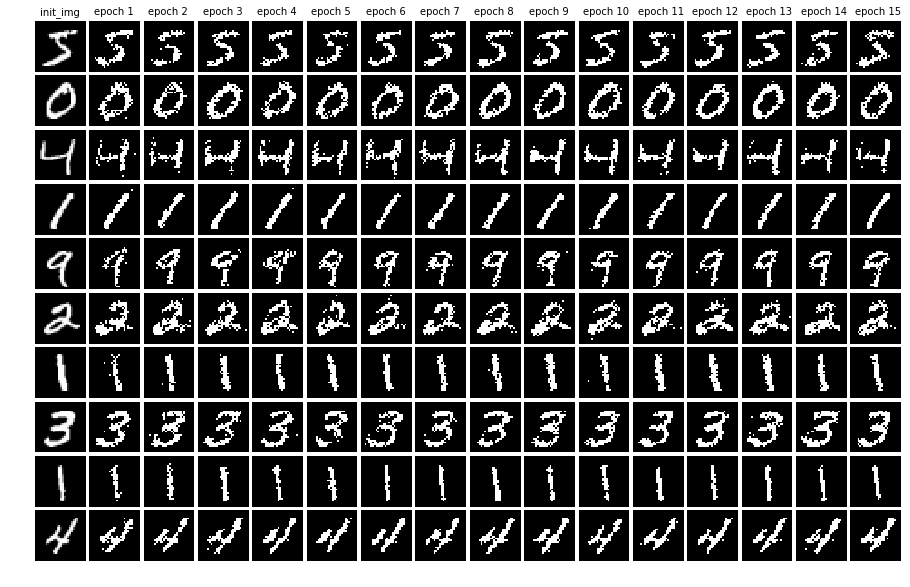

In [12]:
def sorted_numbers(v_in):
    v_out = []
    for elem in v_in:
        if type(elem) == np.int:
            v_out.append(elem)
    return sorted(v_out)


def plot_train_evolution(train_evolution, key='img'):
    print(f'[TRAIN EVOLUTION]'.rjust(68))
    print(f'training_method: {train_evolution["training_method"]}'.rjust(68))
    print(f'gibbs_steps: {train_evolution["gibbs_steps"]}'.rjust(68))
    print(f'batch_size: {train_evolution["batch_size"]}'.rjust(68))
    
    images = np.zeros((10 * (EPOCHS + 1), VIS_DIM))
    i = 0
    for img_idx in range(10):
        for epoch in sorted_numbers(train_evolution.keys()):
            images[i] = norm_img(train_evolution[epoch][key][img_idx].astype('float'))
            i += 1
    
    plt.figure(figsize=(16, 10))
    grid_imgs = grid_vis(images, rows=10, cols=EPOCHS+1)
    add_text([f'init_{key}'] + [f'epoch {epoch+1}' for epoch in range(EPOCHS)])
    plt.imshow(grid_imgs, cmap='gray')
    plt.axis('off')
    plt.show()

plot_train_evolution(rbm_cd_train_evolution, 'img')
plot_train_evolution(rbm_pcd_train_evolution, 'img')
plot_train_evolution(rbm_pt_train_evolution, 'img')

#### 2.3.2 Look at the weights during training

                                                   [TRAIN EVOLUTION]
                                                 training_method: cd
                                                      gibbs_steps: 1
                                                      batch_size: 30


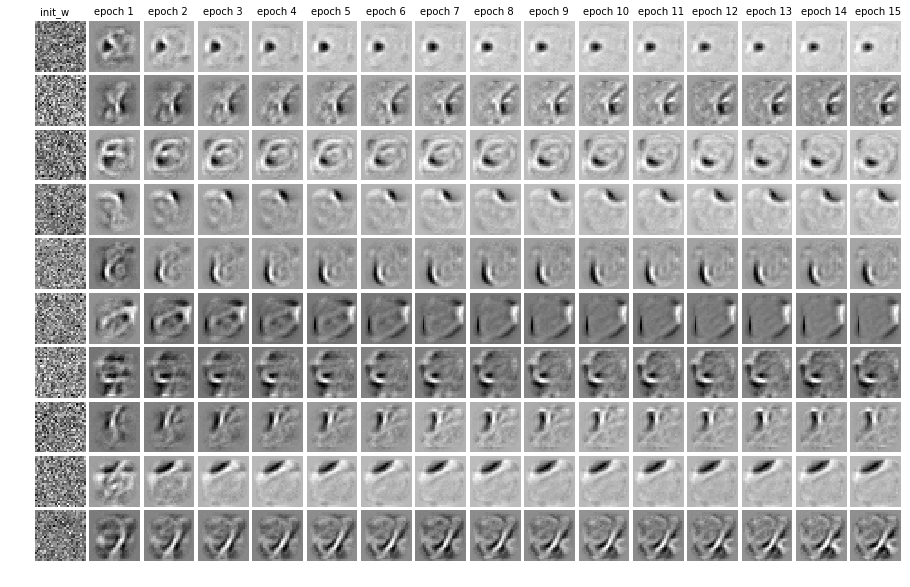

                                                   [TRAIN EVOLUTION]
                                                training_method: pcd
                                                      gibbs_steps: 1
                                                      batch_size: 30


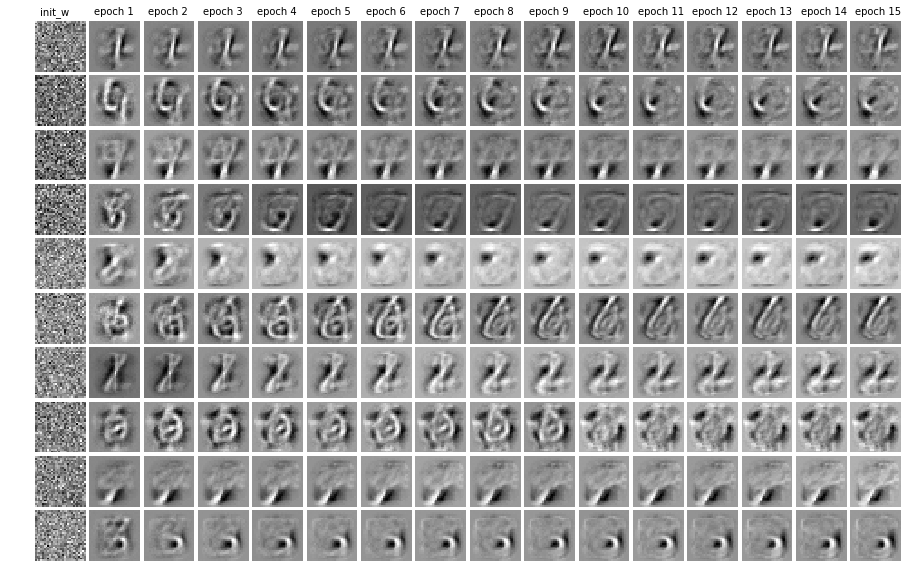

                                                   [TRAIN EVOLUTION]
                                                 training_method: pt
                                                      gibbs_steps: 1
                                                      batch_size: 30


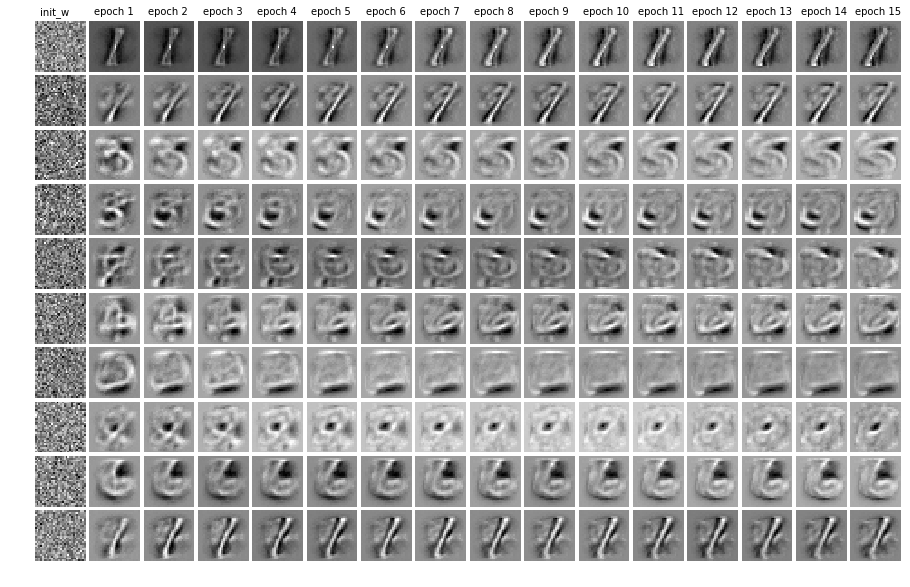

In [13]:
plot_train_evolution(rbm_cd_train_evolution, 'w')
plot_train_evolution(rbm_pcd_train_evolution, 'w')
plot_train_evolution(rbm_pt_train_evolution, 'w')

#### 2.3.3 Look at the final weights

                                                     [FINAL WEIGHTS]
                                                 training_method: cd
                                                      gibbs_steps: 1
                                                      batch_size: 30


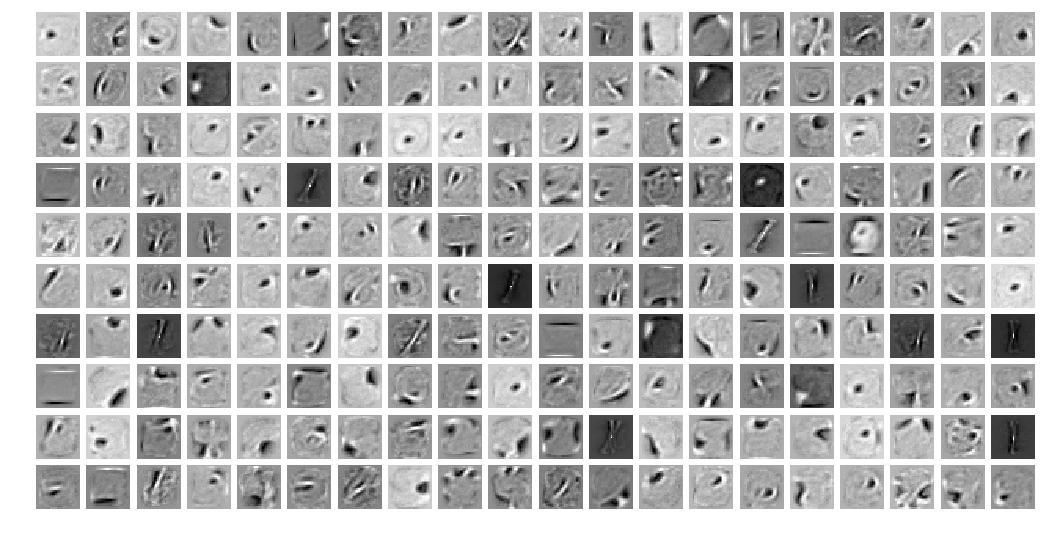

                                                     [FINAL WEIGHTS]
                                                training_method: pcd
                                                      gibbs_steps: 1
                                                      batch_size: 30


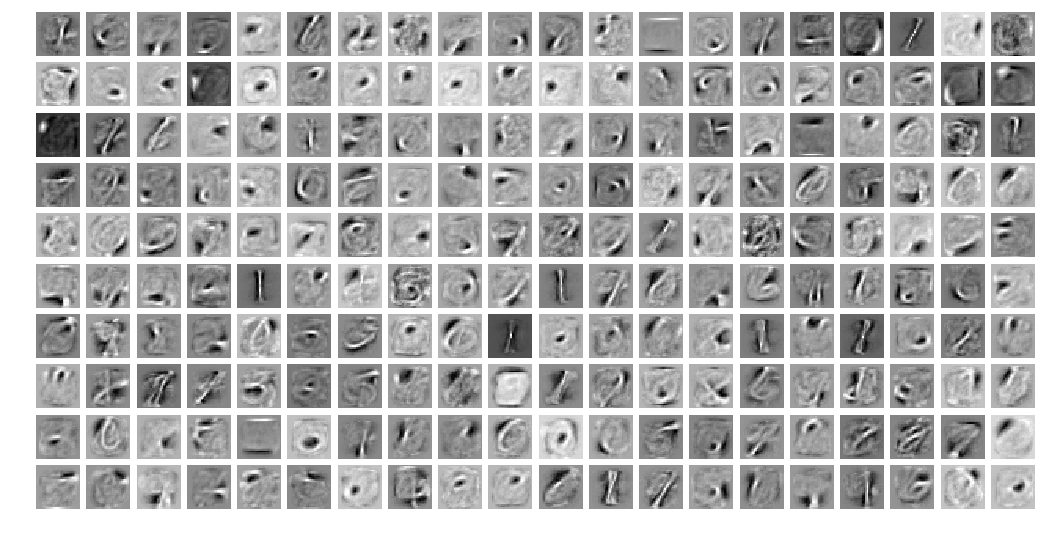

                                                     [FINAL WEIGHTS]
                                                 training_method: pt
                                                      gibbs_steps: 1
                                                      batch_size: 30


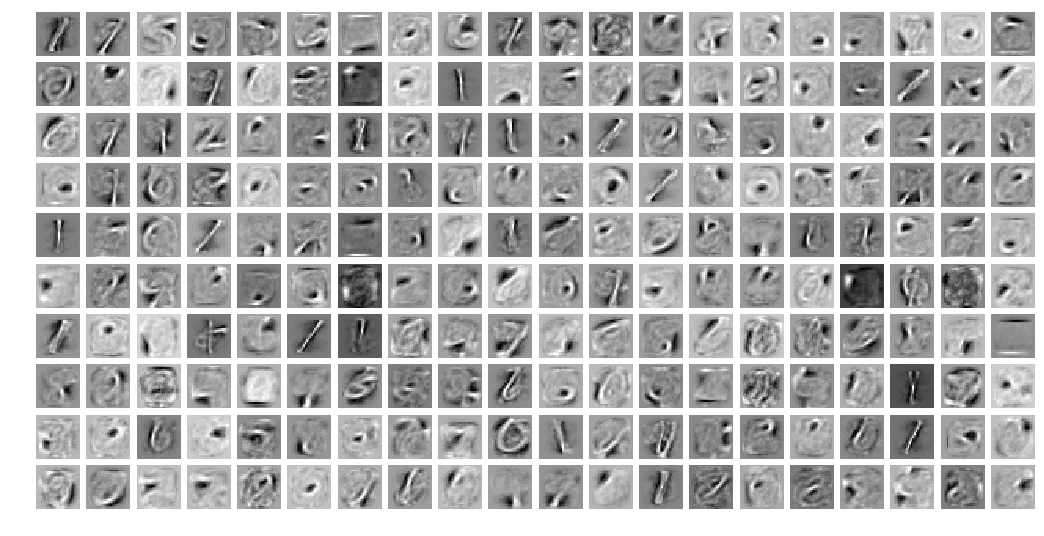

In [14]:
def plot_final_weights(train_evolution):
    print(f'[FINAL WEIGHTS]'.rjust(68))
    print(f'training_method: {train_evolution["training_method"]}'.rjust(68))
    print(f'gibbs_steps: {train_evolution["gibbs_steps"]}'.rjust(68))
    print(f'batch_size: {train_evolution["batch_size"]}'.rjust(68))
          
    images = np.zeros((HIDDEN_DIM, VIS_DIM))
    for w_idx in range(HIDDEN_DIM):
        images[w_idx] = norm_img(train_evolution[EPOCHS - 1]['w'][w_idx])
    
    grid_imgs = grid_vis(images, rows=10, cols=HIDDEN_DIM//10, pad=2)
    plt.figure(figsize=(18, 10))
    plt.imshow(grid_imgs, cmap='gray')
    plt.axis('off')
    plt.show()

plot_final_weights(rbm_cd_train_evolution)
plot_final_weights(rbm_pcd_train_evolution)
plot_final_weights(rbm_pt_train_evolution)

## 3. Applications

In [15]:
test_batch = np.zeros((10, 28 * 28))
for label in range(10):
    test_batch[label] = X_test[y_test==label, :][67]
print(test_batch.shape)

(10, 784)


### 3.1 Digits generation

                                           [SAMPLE FROM TRAINED RBM]
                                                 dataset split: test
                                                 training_method: cd
                                                     gibbs_steps: 30
                                                       plot_every: 2


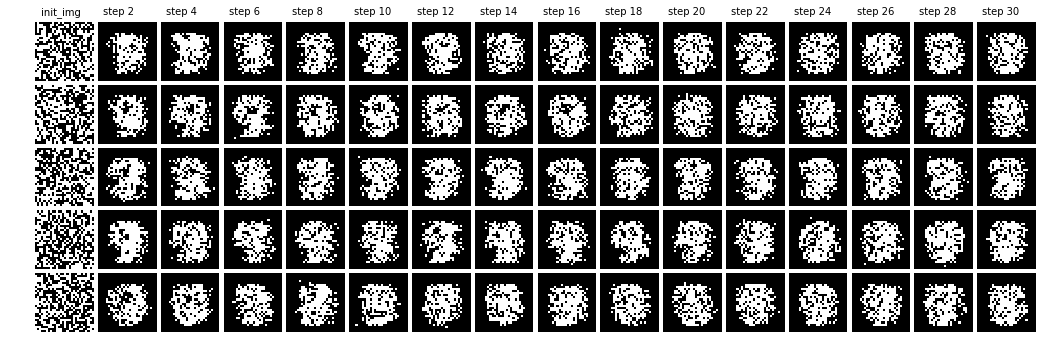

                                           [SAMPLE FROM TRAINED RBM]
                                                 dataset split: test
                                                training_method: pcd
                                                     gibbs_steps: 30
                                                       plot_every: 2


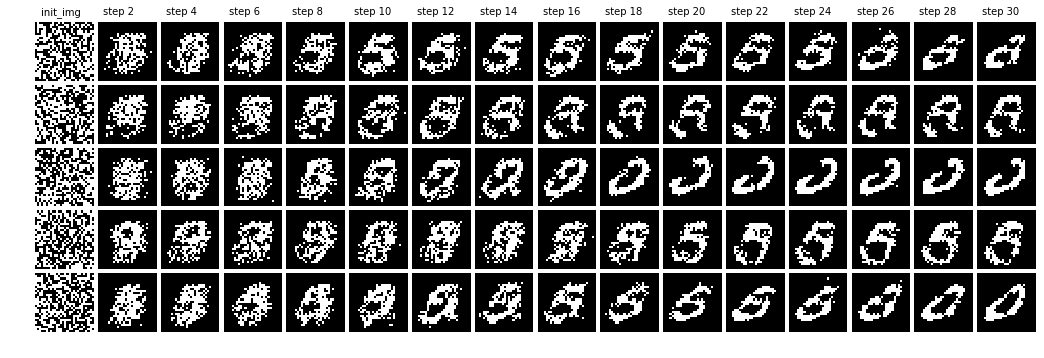

                                           [SAMPLE FROM TRAINED RBM]
                                                 dataset split: test
                                                 training_method: pt
                                                     gibbs_steps: 30
                                                       plot_every: 2


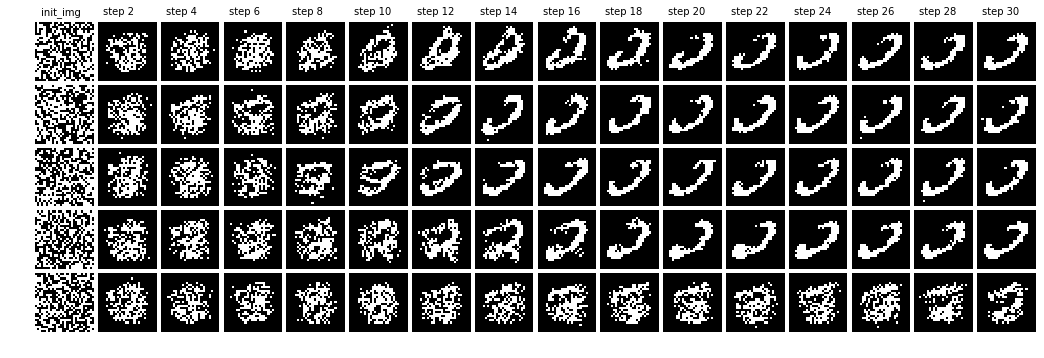

In [16]:
def sample_and_plot(training_method, rbm, batch,
                    gibbs_steps=30, plot_every=2):
    print(f'[SAMPLE FROM TRAINED RBM]'.rjust(68))
    print(f'dataset split: test'.rjust(68))
    print(f'training_method: {training_method}'.rjust(68))
    print(f'gibbs_steps: {gibbs_steps}'.rjust(68))
    print(f'plot_every: {plot_every}'.rjust(68))
    
    samples = {}
    samples[0] = batch.copy()
    for i in range(0, gibbs_steps, plot_every):
        samples[i + plot_every] = rbm.gibbs_sampling(samples[i], k=plot_every)
    
    images = np.zeros((len(batch) * (gibbs_steps//plot_every + 1), VIS_DIM))
    i = 0
    for img_idx in range(len(batch)):
        for gibbs_step in sorted_numbers(samples.keys()):
            images[i] = samples[gibbs_step][img_idx]
            i += 1
    
    plt.figure(figsize=(18, 10))
    grid_imgs = grid_vis(images, rows=len(batch), cols=gibbs_steps//plot_every + 1)
    add_text([f'init_img'] + [f'step {step}' for step in range(plot_every, gibbs_steps + 1, plot_every)])
    plt.imshow(grid_imgs, cmap='gray')
    plt.axis('off')
    plt.show()

random_imgs = np.random.uniform(0, 1, (5, 784)) >= 0.5
sample_and_plot('cd', rbm_cd, random_imgs)
sample_and_plot('pcd', rbm_pcd, random_imgs)
sample_and_plot('pt', rbm_pt, random_imgs)

                                           [SAMPLE FROM TRAINED RBM]
                                                 dataset split: test
                                                 training_method: cd
                                                     gibbs_steps: 30
                                                       plot_every: 2


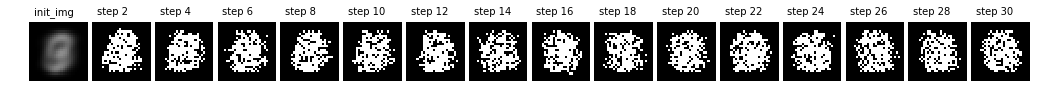

                                           [SAMPLE FROM TRAINED RBM]
                                                 dataset split: test
                                                training_method: pcd
                                                     gibbs_steps: 30
                                                       plot_every: 2


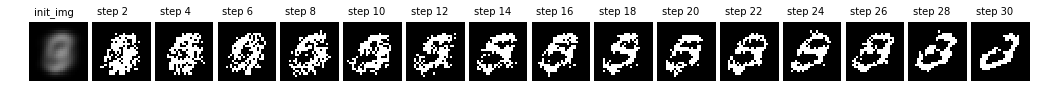

                                           [SAMPLE FROM TRAINED RBM]
                                                 dataset split: test
                                                 training_method: pt
                                                     gibbs_steps: 30
                                                       plot_every: 2


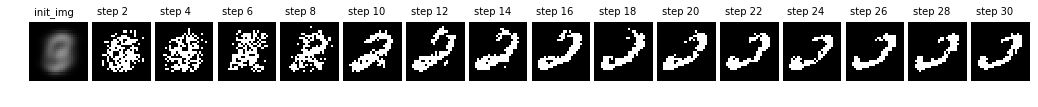

In [17]:
sample_and_plot('cd', rbm_cd, avg_train_img.T)
sample_and_plot('pcd', rbm_pcd, avg_train_img.T)
sample_and_plot('pt', rbm_pt, avg_train_img.T)

                                           [SAMPLE FROM TRAINED RBM]
                                                 dataset split: test
                                                 training_method: cd
                                                     gibbs_steps: 30
                                                       plot_every: 2


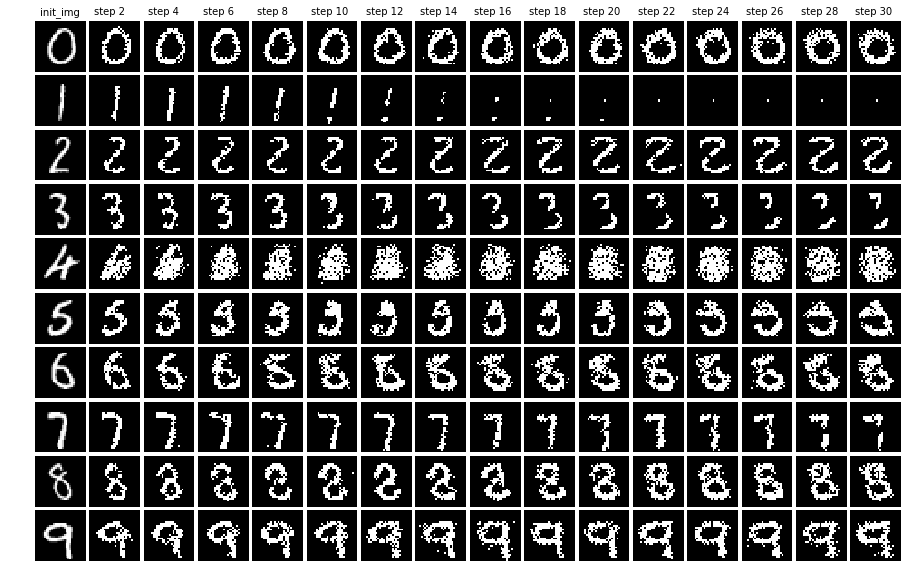

                                           [SAMPLE FROM TRAINED RBM]
                                                 dataset split: test
                                                training_method: pcd
                                                     gibbs_steps: 30
                                                       plot_every: 2


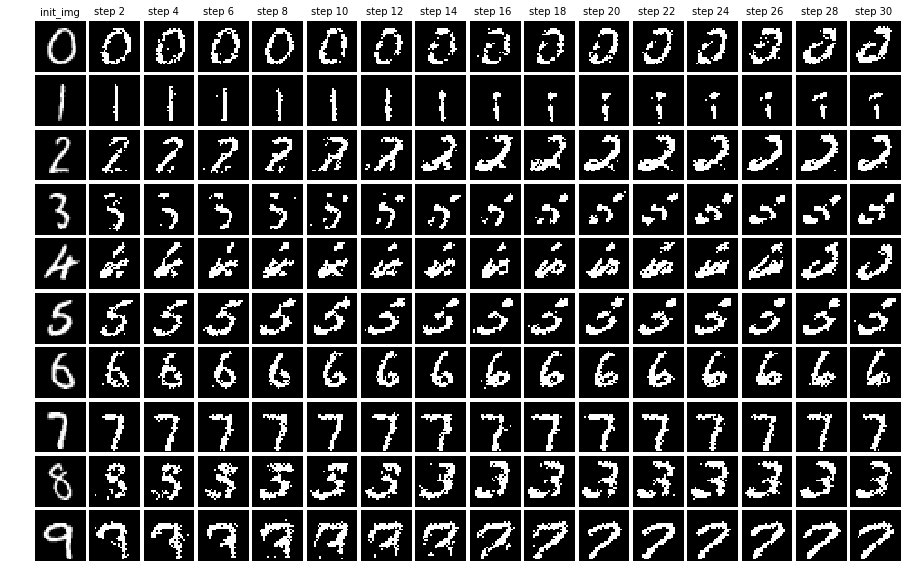

                                           [SAMPLE FROM TRAINED RBM]
                                                 dataset split: test
                                                 training_method: pt
                                                     gibbs_steps: 30
                                                       plot_every: 2


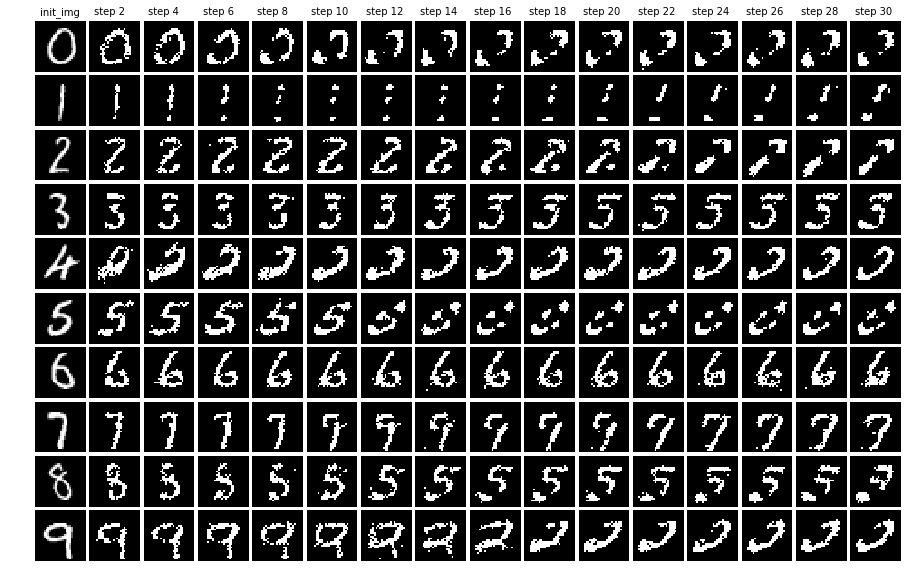

In [18]:
sample_and_plot('cd', rbm_cd, test_batch)
sample_and_plot('pcd', rbm_pcd, test_batch)
sample_and_plot('pt', rbm_pt, test_batch)

### 3.2 Digits restoration

                                           [SAMPLE FROM TRAINED RBM]
                                                 dataset split: test
                                                 training_method: cd
                                                     gibbs_steps: 30
                                                       plot_every: 2


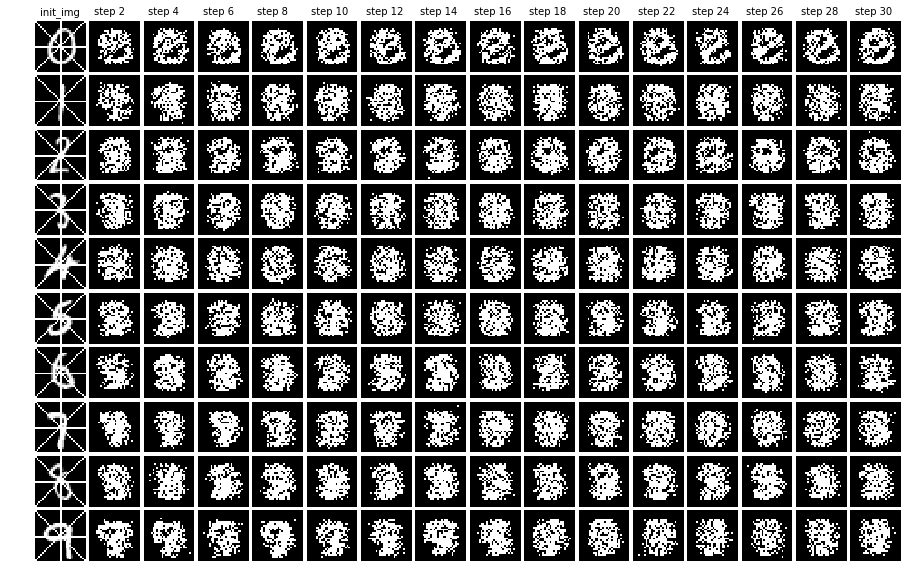

                                           [SAMPLE FROM TRAINED RBM]
                                                 dataset split: test
                                                training_method: pcd
                                                     gibbs_steps: 30
                                                       plot_every: 2


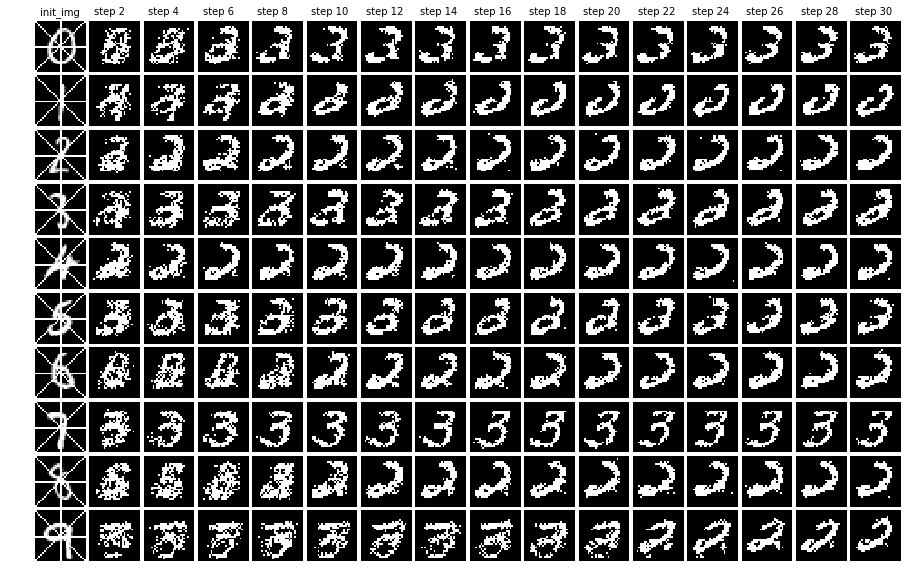

                                           [SAMPLE FROM TRAINED RBM]
                                                 dataset split: test
                                                 training_method: pt
                                                     gibbs_steps: 30
                                                       plot_every: 2


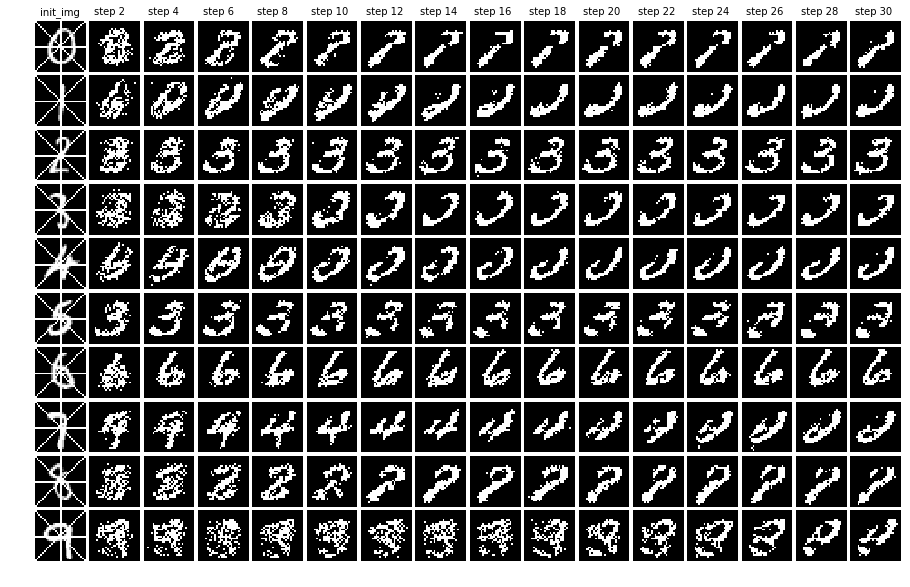

In [19]:
corrupted_test_batch = test_batch.copy()
corrupted_test_batch[:, np.arange(14, 784, 28)] = 1
corrupted_test_batch[:, np.arange(0, 784, 29)] = 1
corrupted_test_batch[:, np.arange(27, 784, 27)] = 1
corrupted_test_batch[:, np.arange(784 // 2, 784 // 2 + 28)] = 1

sample_and_plot('cd', rbm_cd, corrupted_test_batch)
sample_and_plot('pcd', rbm_pcd, corrupted_test_batch)
sample_and_plot('pt', rbm_pt, corrupted_test_batch)

                                           [SAMPLE FROM TRAINED RBM]
                                                 dataset split: test
                                                 training_method: cd
                                                     gibbs_steps: 30
                                                       plot_every: 2


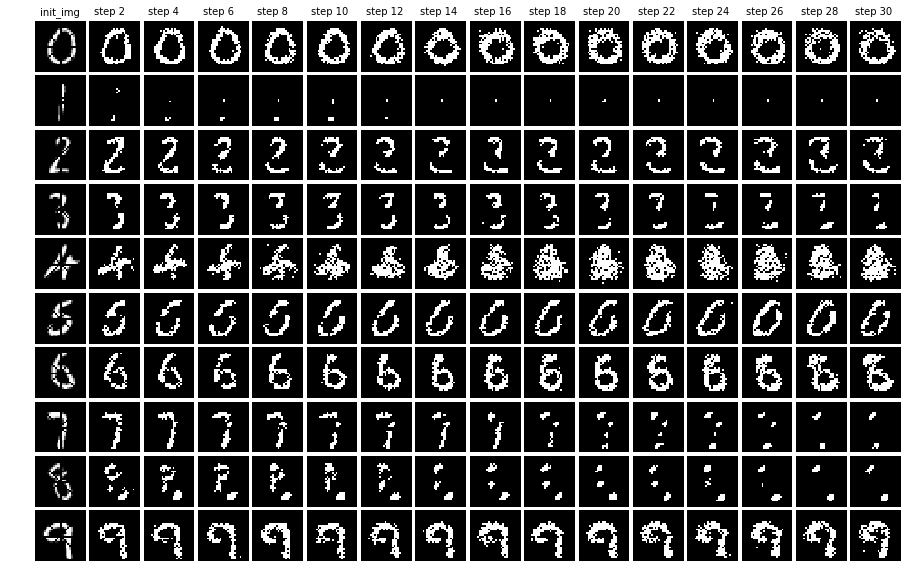

                                           [SAMPLE FROM TRAINED RBM]
                                                 dataset split: test
                                                training_method: pcd
                                                     gibbs_steps: 30
                                                       plot_every: 2


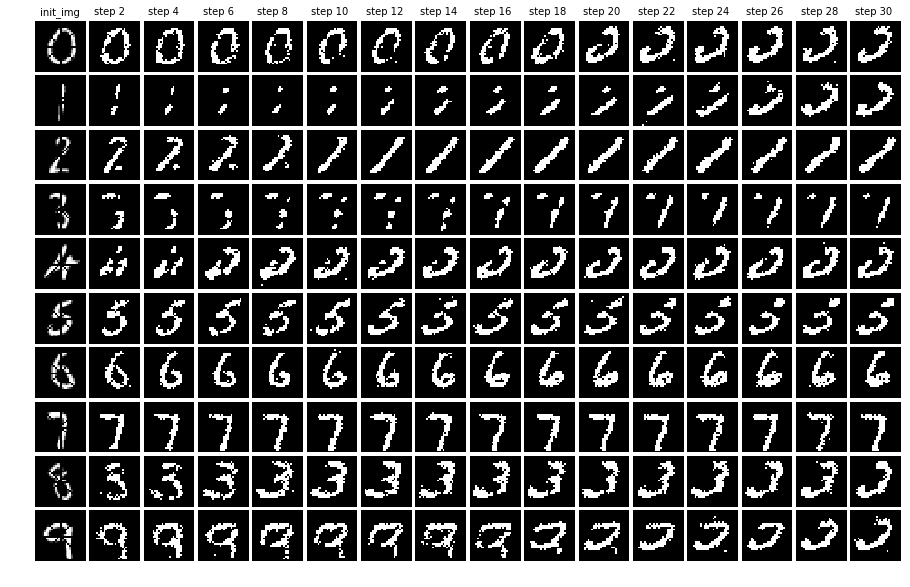

                                           [SAMPLE FROM TRAINED RBM]
                                                 dataset split: test
                                                 training_method: pt
                                                     gibbs_steps: 30
                                                       plot_every: 2


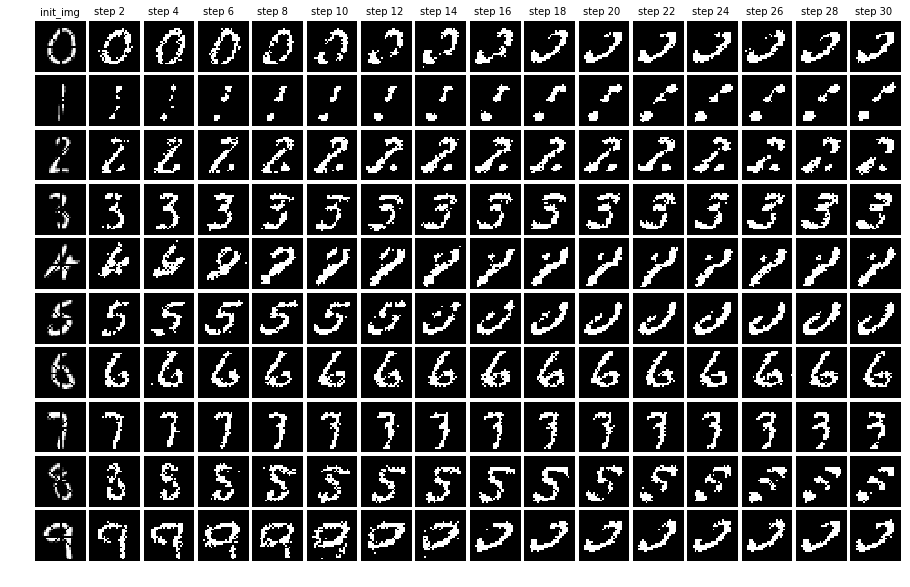

In [20]:
corrupted_test_batch = test_batch.copy()
corrupted_test_batch[:, np.arange(14, 784, 28)] = 0
corrupted_test_batch[:, np.arange(0, 784, 29)] = 0
corrupted_test_batch[:, np.arange(27, 784, 27)] = 0
corrupted_test_batch[:, np.arange(784 // 2, 784 // 2 + 28)] = 0

sample_and_plot('cd', rbm_cd, corrupted_test_batch)
sample_and_plot('pcd', rbm_pcd, corrupted_test_batch)
sample_and_plot('pt', rbm_pt, corrupted_test_batch)

                                           [SAMPLE FROM TRAINED RBM]
                                                 dataset split: test
                                                 training_method: cd
                                                     gibbs_steps: 30
                                                       plot_every: 2


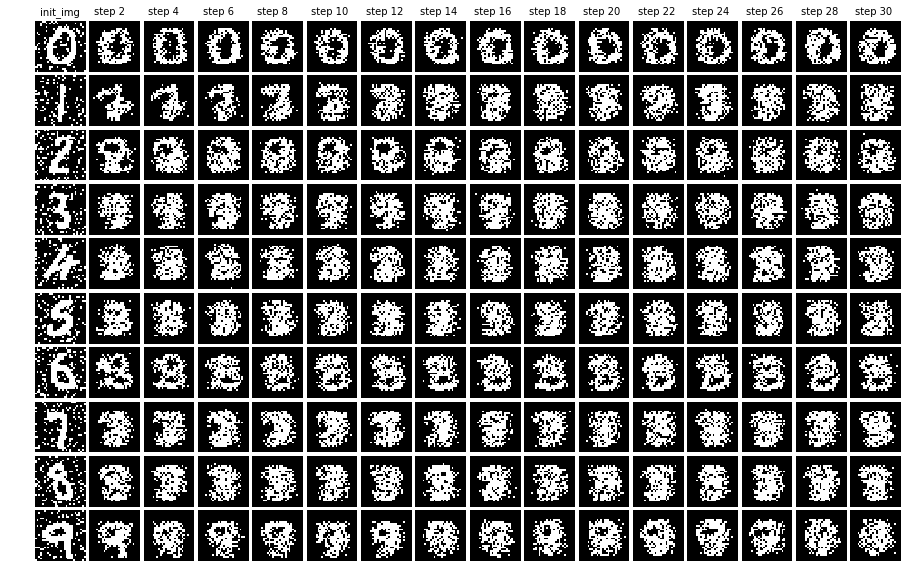

                                           [SAMPLE FROM TRAINED RBM]
                                                 dataset split: test
                                                training_method: pcd
                                                     gibbs_steps: 30
                                                       plot_every: 2


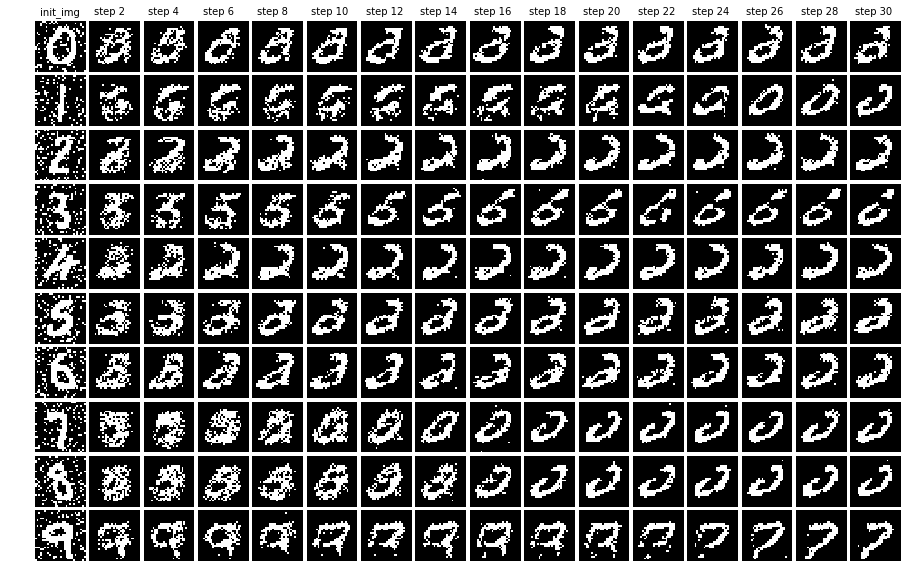

                                           [SAMPLE FROM TRAINED RBM]
                                                 dataset split: test
                                                 training_method: pt
                                                     gibbs_steps: 30
                                                       plot_every: 2


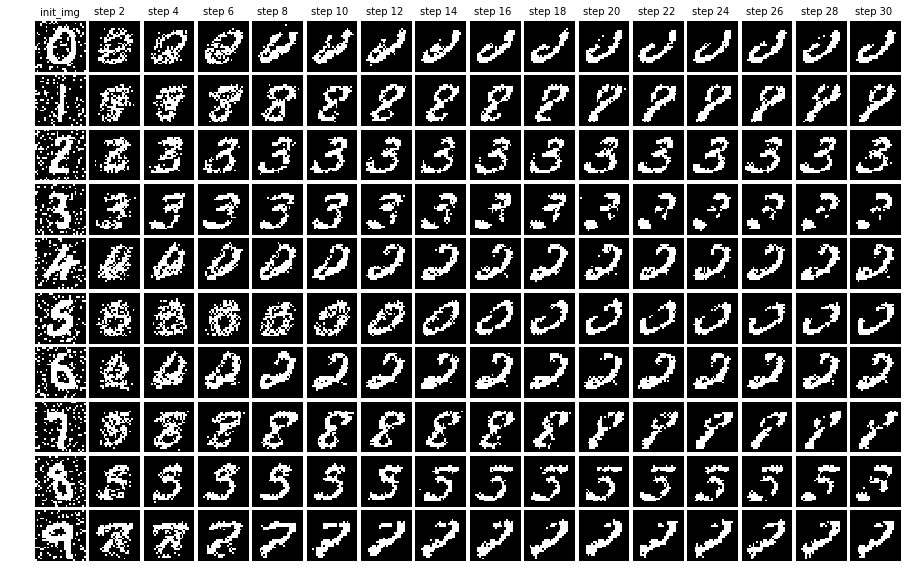

In [21]:
random_noise = np.random.uniform(0, 1, test_batch.shape) > 0.85
corrupted_test_batch = np.logical_or(test_batch, random_noise)

sample_and_plot('cd', rbm_cd, corrupted_test_batch)
sample_and_plot('pcd', rbm_pcd, corrupted_test_batch)
sample_and_plot('pt', rbm_pt, corrupted_test_batch)